# Starbucks Capstone Challenge

## Introduction From Udacity

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Table of Content:
1. [Introduction / Business Understanding](#1)

2. [Data Understanding](#2)
    - [Inspect the Dataset](#2.1)
    - [Cleaning the Datasets](#2.2)

3. [EDA](#3)

4. [Modeling and Evaluation](#4)
    - [Creating the Right Label](#4.1) 
    - [Modeling and Evaluation](#4.2)

5. [Conclusion](#5)

<a id="1"></a>
## 1. Introduction from Student

Here are the business questions that I would like to answer.
- Q1: Which one is the most popular offer?
- Q2: Do different groups of people react different to offers?
- Q3: Do people generally view and then use the offer? or they use the offer without notice it?
- Q4: Which group of people is more likely to use the offer or make a purchase WITHOUT viewing the offer, if there is such a group?
- Q5: Which type of offer is more likely to be used WITHOUT being viewed, if there is one?

I focused only on the BOGO and discount offer for this analysis for 2 main reasons. One was because I believed BOGO and discount offers had a different business logic from the informational offer/advertisement. For BOGO and discount offers, we want to identify people who used them without knowing it, so that we are not giving money for no gains. For advertisement, we want to identify which group is being incentive to spend more. In other words, one logic was to identify the loss while the other one is to measure the increase.

Another reason is linked to the first reason. Due to the different busniess logic, I would like to limte the scope of this analysis. Therefore, I did not analysis the information offer type.

The metrics I would use to measure my success are:

1) If I had a clear answer to all the business questions that I listed.
2) If I could build a machine model that could help predicting which customer will 'free ride' the offer.


<a id="2"></a>
## 2. Data Understanding

<a id="2.1"></a>
## 2.1 Inspect the Dataset:

In [1]:
import pandas as pd
import numpy as np
import math
import json

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
profile.sample(5)

,gender,age,id,became_member_on,income
7786,M,44,ba3d4e6aa3a64d0c8a5262a374a05f6f,20160624,66000.0
9818,F,63,fd13cda6e91f454f87eab139205e45cd,20180531,107000.0
5059,M,54,f136a036cafd4d22a39eeb3402c8559b,20180112,63000.0
15921,F,20,bf93fed7206e4e14ae7e04abcb9b1445,20170514,48000.0
3772,F,65,842f6309498349c384c691cea552c52c,20180112,80000.0


In [3]:
transcript.sample(5)

,person,event,value,time
96476,6959ae9c142a45e8ac7fe34505cc0d41,transaction,{'amount': 22.26},258
242137,72412f41d944472dbba2183ae9af8a8e,transaction,{'amount': 26.53},564
100739,6ee360b5c2ed4232b41fa2cc677b23f7,transaction,{'amount': 13.42},276
291483,f6e6b0f97b004170b65794fdf80294db,transaction,{'amount': 26.7},648
263906,1ee3e36220f5437fb0523779f9318b85,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,582


In [4]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


To do any analysis, we will need to combine the 3 dataset. We will clean the profile and transcript dataset first, and merge combine them. Then we will combine it with portfolio. Let's start with cleaning the profile dataset.

<a id="2.2"></a>
## 2.2 Cleaning the Datasets

### Merge Profile and Transcript Datasets

In [5]:
profile.info() #inspect the datatype and null vlaues

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


* gender and income - has the same amount of null values
* became_member_on - not in datatime format

In [6]:
profile.describe() #inspect the values

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


* age - max value is 118

In [7]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


* value - needs to be seperated by offer_id and amount

In [8]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


* time - in hours, will be easier to see if change to days.

In [9]:
#merge the two dataset
df = transcript.merge(profile, left_on='person', right_on='id', how='outer')

In [10]:
#let's look at the null values first
null_profile = df[df['gender'].isnull()]

null_profile.sample(5)

,person,event,value,time,gender,age,id,became_member_on,income
98695,adf921d115964c47b48679b6fdc397ed,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},168,None,118,adf921d115964c47b48679b6fdc397ed,20170705,NaN
116185,763fec6028f044a0ad4d5864b32cef46,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},336,None,118,763fec6028f044a0ad4d5864b32cef46,20171104,NaN
51040,3af266992b2448599ace40a81088a951,transaction,{'amount': 0.91},354,None,118,3af266992b2448599ace40a81088a951,20150130,NaN
210378,c61e90bc54de43a1888f229d46d62daf,transaction,{'amount': 5.15},708,None,118,c61e90bc54de43a1888f229d46d62daf,20161108,NaN
235463,319df0da652f452eb8a5876e9ebd17d4,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},576,None,118,319df0da652f452eb8a5876e9ebd17d4,20170820,NaN


In [11]:
#confirm if null values in gender == null in income
null_profile['income'].mean()

nan

In [12]:
#confirm if all null values has age == 118
null_profile['age'].mean()

118.0

In [13]:
#do null profiles ever completed any offers?
null_profile['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [103]:
#null profile offer completion rate
null_rate = len(null_profile[null_profile['event']=='offer completed'])/len(null_profile[null_profile['event']=='offer received'])

print('offer completion rate for profiles that have null values is {}'.format(null_rate))

offer completion rate for profiles that have null values is 0.11610065466448445


In [104]:
#complete profile offer completion rate
com_profile = df[df['gender'].notnull()]

regular_rate = len(com_profile[com_profile['event']=='offer completed'])/len(com_profile[com_profile['event']=='offer received'])

print('offer completion rate for profiles that have null values is {}'.format(regular_rate))

offer completion rate for profiles that have null values is 0.4878723628216117


### Insight 1: If a customer has an incomplete profile, for example, with missing gender or age, the chance of that customer participating in an offer is significantly lower.

Due to the incomplete information and they are significantly less likely to use our offer. I decided to drop them for now. However, I did make the assumption that they are likely to spend less money as well due to the low degree of participation/invovlement, without analysising the amount of transaction that they made.

### Cleaning Round 1 - correct data types and formats

In [16]:
def clean_df(df):
    clean_df = df[df['gender'].notnull()].copy() #drop null values
    clean_df.drop('id', axis=1, inplace=True) #drop the repeated column after combine
    
    #change became_member_on to datetime formate
    clean_df['became_member_on'] = pd.to_datetime(clean_df['became_member_on'], format='%Y%m%d')
    # create a new column that has the year which customers become members
    clean_df['year'] = clean_df['became_member_on'].apply(lambda x: str(x)[:4])
    
    #change the time in hours to days, rounding up
    clean_df['days'] = clean_df['time'].apply(lambda x: int(x / 24) + (x % 24 > 0))
    
    #clean the value column
    clean_df['offer_id'] = clean_df['value'].apply(lambda x: x['offer id'] if 'offer id' in x else x['offer_id'] if 'offer_id' in x else np.nan)
    clean_df['amount'] = clean_df['value'].apply(lambda x: x.get('amount', 0))
    clean_df.drop(['value'], axis=1, inplace=True)
    
    clean_df = clean_df.reset_index(drop=True)
    
    return clean_df
    

In [17]:
clean_df = clean_df(df)
clean_df.head()

,person,event,time,gender,age,became_member_on,income,year,days,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,F,75,2017-05-09,100000.0,2017,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,F,75,2017-05-09,100000.0,2017,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,F,75,2017-05-09,100000.0,2017,6,NaN,19.89
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,F,75,2017-05-09,100000.0,2017,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,F,75,2017-05-09,100000.0,2017,6,NaN,17.78


### Merge Portfolio Dataset

In [18]:
portfolio['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [19]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


* channel - in a list, make them very hard to analyze
* no null values - good

In [20]:
#merge the three datasets
full_df = clean_df.merge(portfolio, left_on='offer_id', right_on='id', how='outer')
full_df.drop(['id'], axis=1, inplace=True) #drop the repeated column
full_df.sample(5)

,person,event,time,gender,age,became_member_on,income,year,days,offer_id,amount,reward,channels,difficulty,duration,offer_type
16068,f970eafddcb34154aa4d646b4a71ca34,transaction,426,F,66,2015-10-01,87000.0,2015,18,NaN,22.63,NaN,NaN,NaN,NaN,NaN
37991,6de6f7e081af455886287068f1b40419,transaction,354,F,25,2018-04-22,67000.0,2018,15,NaN,2.79,NaN,NaN,NaN,NaN,NaN
256392,4fe634565ad74b97b8b1412ca69914d6,offer received,408,F,49,2018-05-27,73000.0,2018,17,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,5.0,"[web, email]",20.0,10.0,discount
232725,e820e95254a24e9abe9704555f8bbee2,offer received,576,F,52,2018-07-07,56000.0,2018,24,2298d6c36e964ae4a3e7e9706d1fb8c2,0.00,3.0,"[web, email, mobile, social]",7.0,7.0,discount
6671,28d6452ecc534860b70ab53d92dd1acf,offer received,336,F,52,2015-12-17,84000.0,2015,14,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,5.0,"[web, email, mobile]",5.0,7.0,bogo


In [21]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   person            272762 non-null  object        
 1   event             272762 non-null  object        
 2   time              272762 non-null  int64         
 3   gender            272762 non-null  object        
 4   age               272762 non-null  int64         
 5   became_member_on  272762 non-null  datetime64[ns]
 6   income            272762 non-null  float64       
 7   year              272762 non-null  object        
 8   days              272762 non-null  int64         
 9   offer_id          148805 non-null  object        
 10  amount            272762 non-null  float64       
 11  reward            148805 non-null  float64       
 12  channels          148805 non-null  object        
 13  difficulty        148805 non-null  float64       
 14  dura

### Cleaning Round 2 - turn categorical data to numerical for analysis

* event - 
    - 0-'offer received'
    - 1-'offer viewed'
    - 2-'offer completed'
    - 3-'transaction'
* gender - 
    - 0-F
    - 1-M
    - 3-O
* channels -                      
    - 0-[web, email]
    - 1-[email, mobile, social] 
    - 2-[web, email, mobile]
    - 3-[web, email, mobile, social]
* offer_type - 
    - 0-'bogo'
    - 2-'informational'
    - 3-'discount'
* year -
    - 0-'2013'
    - 1-'2014'
    - 2-'2015'
    - 3-'2016'
    - 4-'2017'
    - 5-'2018'   

In [105]:
#Let's see the orders of the variables
print((full_df['offer_type'].unique()), (full_df['event'].unique()), full_df['gender'].unique(), full_df['year'].unique())

['bogo' nan 'informational' 'discount'] ['offer received' 'offer viewed' 'offer completed' 'transaction'] ['F' 'M' 'O'] ['2017' '2018' '2015' '2016' '2014' '2013']


In [23]:
def cate2num(df, cols):
    """
    input: 
    df: the dataframe
    cols: a list of cols that are categorical variabls and want to turn into integers. However order does not matter
    for these categorical variables.
    
    output:
    dataframe with old columns + additional columns that turned categorial variables into numbers.
    The numbers only indicates different categories, not orders.
    """
    for col in cols:
        #get all the unique categories in the column
        array = df[col].unique()
        
        #get the numbers of categories
        value_nums = len(array)
        
        #create new column
        df[col+'_id'] = df[col]

        for i in range(value_nums):
            #replace the variable with a number in the newly created column
            df[col+'_id'] = np.where(df[col]==array[i] , i, df[col+'_id'])
    
    return df


In [24]:
def clean_allcat(df, cols):
    """
    df: the df you want to clean
    cols: the cols that can be cleaned by using cate2num
    
    output:
    a dataframe with all orginal columns + new columns that turned the following categorical columns into
    numerical values.
    
    columns are ['gender', 'event', 'offer_type', 'year', channels']
    
    """
    #normal cat variables to numbers
    cleaned_df = cate2num(df, cols)
    
    #years
    years = df['year'].unique()
    year_sorted = sorted([int(x) for x in list(years)])
    cleaned_df['year_id'] = df['year']
    for i in range(len(year_sorted)):
        cleaned_df['year_id'] = np.where(cleaned_df['year_id']==str(year_sorted[i]) , i, cleaned_df['year_id'])

    #channelId
    col = 'channels'
    channelTye_id = df[col].copy()
    length = len(df)
    
    for x in range(length):
        if df[col][x] == ['web', 'email', 'mobile', 'social']:
            channelTye_id[x] = 3
        elif df[col][x] == ['web', 'email', 'mobile']:
            channelTye_id[x] = 2
        elif df[col][x] == ['email', 'mobile', 'social']:
            channelTye_id[x] = 1
        elif df[col][x] == ['web', 'email']:
            channelTye_id[x] = 0
            
    cleaned_df['channelTye_id'] = channelTye_id

    return cleaned_df


In [25]:
full_clean = clean_allcat(full_df, ['gender', 'event', 'offer_type'])

full_clean.sample(5)

,person,event,time,gender,age,became_member_on,income,year,days,offer_id,...,reward,channels,difficulty,duration,offer_type,gender_id,event_id,offer_type_id,year_id,channelTye_id
102781,ba5f8967f25141a8b9c153effd96faf2,transaction,282,M,58,2018-07-13,50000.0,2018,12,NaN,...,NaN,NaN,NaN,NaN,NaN,1,3,NaN,5,NaN
182763,8bad0c89bddb49c4acf5c73c93657731,offer received,504,F,77,2018-01-10,46000.0,2018,21,f19421c1d4aa40978ebb69ca19b0e20d,...,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,0,0,0,5,3
147653,e5bf376b48c247198f5b6dccc64811be,offer viewed,168,F,81,2017-10-28,96000.0,2017,7,5a8bc65990b245e5a138643cd4eb9837,...,0.0,"[email, mobile, social]",0.0,3.0,informational,0,1,2,4,1
230915,2100a915e90a4078b87eefe030c6aba3,offer received,504,F,66,2018-04-23,52000.0,2018,21,2298d6c36e964ae4a3e7e9706d1fb8c2,...,3.0,"[web, email, mobile, social]",7.0,7.0,discount,0,0,3,5,3
92832,ad43ddab7325414f9f8ffa7331a0f13f,transaction,468,M,69,2018-04-20,78000.0,2018,20,NaN,...,NaN,NaN,NaN,NaN,NaN,1,3,NaN,5,NaN


### Seperate into different datasets

In [26]:
#df with only offer records
offer_df = full_clean[full_clean['offer_id'].notnull()]

#df with only bogo and discount offer type
offer0_3 = full_clean.loc[(full_clean['offer_type_id']==0) | (full_clean['offer_type_id']==3)]

In [27]:
offer_df.sample(5)

,person,event,time,gender,age,became_member_on,income,year,days,offer_id,...,reward,channels,difficulty,duration,offer_type,gender_id,event_id,offer_type_id,year_id,channelTye_id
206604,7b3b36fdf2da4b9485571026a4c1a128,offer received,336,M,66,2017-10-20,69000.0,2017,14,3f207df678b143eea3cee63160fa8bed,...,0.0,"[web, email, mobile]",0.0,4.0,informational,1,0,2,4,2
251457,ca265792e65949d79b2b0e91bdd31c57,offer received,408,F,34,2017-07-22,37000.0,2017,17,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,5.0,"[web, email]",20.0,10.0,discount,0,0,3,4,0
225237,4d6012820ac14c799000736b3f631259,offer received,336,M,47,2018-05-31,54000.0,2018,14,fafdcd668e3743c1bb461111dcafc2a4,...,2.0,"[web, email, mobile, social]",10.0,10.0,discount,1,0,3,5,3
146804,96ae94b7eb5e404bbe7a5fe07a7d7035,offer viewed,168,M,38,2015-12-15,34000.0,2015,7,5a8bc65990b245e5a138643cd4eb9837,...,0.0,"[email, mobile, social]",0.0,3.0,informational,1,1,2,2,1
260296,b5089461bd1a427c8874d5e36d3a2d40,offer completed,636,F,50,2017-08-05,50000.0,2017,27,4d5c57ea9a6940dd891ad53e9dbe8da0,...,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,0,2,0,4,3


In [28]:
offer0_3.sample(5)

,person,event,time,gender,age,became_member_on,income,year,days,offer_id,...,reward,channels,difficulty,duration,offer_type,gender_id,event_id,offer_type_id,year_id,channelTye_id
177732,3c88696ac23741cb8a709d656fe5ccdf,offer completed,0,M,50,2016-05-30,86000.0,2016,0,f19421c1d4aa40978ebb69ca19b0e20d,...,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,1,2,0,3,3
247579,6c2f16e45e8442309672bcd9b50940ea,offer viewed,540,F,87,2017-10-25,40000.0,2017,23,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,5.0,"[web, email]",20.0,10.0,discount,0,1,3,4,0
160685,a08140db94454cbe8340002e42d56f82,offer completed,684,M,58,2016-10-11,77000.0,2016,29,ae264e3637204a6fb9bb56bc8210ddfd,...,10.0,"[email, mobile, social]",10.0,7.0,bogo,1,2,0,3,1
215640,a814c06cc66a42fda88d324956f7a543,offer received,504,M,68,2014-04-16,40000.0,2014,21,fafdcd668e3743c1bb461111dcafc2a4,...,2.0,"[web, email, mobile, social]",10.0,10.0,discount,1,0,3,1,3
215437,6255fc72d0194be9b83b21395c6c500e,offer completed,468,M,68,2018-04-14,61000.0,2018,20,fafdcd668e3743c1bb461111dcafc2a4,...,2.0,"[web, email, mobile, social]",10.0,10.0,discount,1,2,3,5,3


<a id="3"></a>
## 3. EDA

**Goal: to identify the ways that can adovid giving offers that were used WITHOUT being viewed.**

Review Business Questions:
- Q1: Which one is the most popular offer?
- Q2: Do different groups of people react different to offers?
- Q3: Do people generally view and then use the offer? or they use the offer without notice it?
- Q4: Which group of people is more likely to use the offer or make a purchase WITHOUT viewing the offer, if there is such a group?
- Q5: Which type of offer is more likely to be used WITHOUT being viewed, if there is one?

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

### Q1: which offer is the most popular?

In [117]:
print('The total counts of different events for BOGO offer is')
print(offer0_3[offer0_3["offer_type_id"]==0]['event'].value_counts())

print('\n\nThe total counts of different events for discount offer is')
print(offer0_3[offer0_3["offer_type_id"]==3]['event'].value_counts())

The total counts of different events for BOGO offer is
offer received     26537
offer viewed       22039
offer completed    15258
Name: event, dtype: int64


The total counts of different events for discount offer is
offer received     26664
offer viewed       18461
offer completed    17186
Name: event, dtype: int64


Text(0.5, 1.0, 'Totoal counts of 0-BOGO offer vs. 3-discount offer\n')

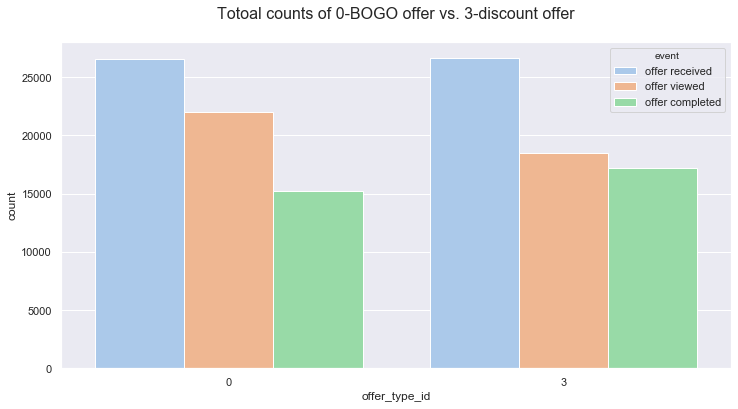

In [118]:
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(x="offer_type_id", hue="event", data=offer0_3, palette="pastel")
plt.title("Totoal counts of 0-BOGO offer vs. 3-discount offer\n", fontsize=16)

In [31]:
#offer0_3.groupby(['offer_id'])['days'].mean()
#offer0_3.groupby(['offer_id'])['days'].min()
#offer0_3.groupby(['offer_id'])['days'].max()

In [32]:
#dataframe with only bogo offer
bogo = offer0_3[offer0_3['offer_type_id']==0]
#dataframe with only discount offer
discount = offer0_3[offer0_3['offer_type_id']==3]

def event_counts(df):
    """
    output:
    returns the counts of each individual event
    
    for example:
    There are 3 different events in this dataset - offer completed/viewed/received.
    The result will return 3 numbers that are the total counts of each of these events.
    """
    events = df['event_id'].unique()
    counts = []
    for event in events:
        count = len(df[df['event_id'] == event])
        yield count
    

In [33]:
#event counts of BOGO offer
bogo0, bogo1, bogo2 = event_counts(bogo)

#event counts of discount offer
discount0, discount1, discount2 = event_counts(discount)

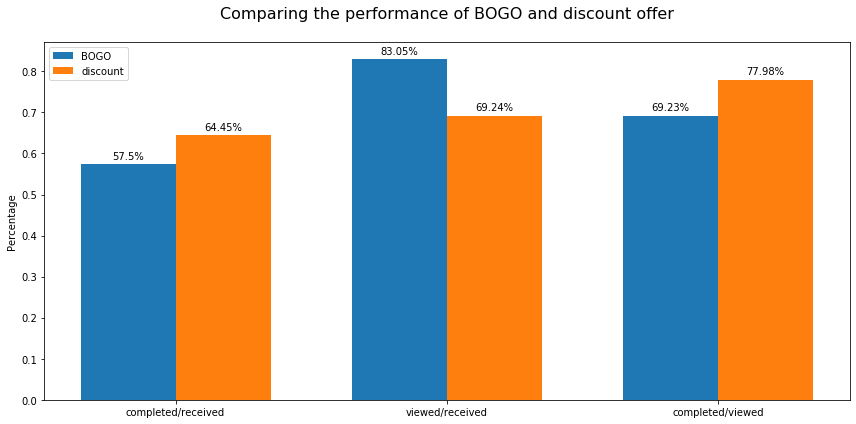

In [34]:
"""
BOGO and discount offers' performances in terms of percentage
"""

labels = ['completed/received', 'viewed/received', 'completed/viewed']
bogo_performance = [bogo2/bogo0, bogo1/bogo0, bogo2/bogo1]
discount_performance = [discount2/discount0, discount1/discount0, discount2/bogo1]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, bogo_performance, width, label='BOGO')
rects2 = ax.bar(x + width/2, discount_performance, width, label='discount')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Comparing the performance of BOGO and discount offer\n', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}%'.format(round(height*100, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### Insight 2: Discount offer is more popular because 
not only the absolute number of 'offer completed' is slightly higher than BOGO offer, its overall completed/received rate is also about 7% higher. However, BOGO offer has a much greater chance to be viewed or seen by customers.

### Q2: Do different groups of people react different to offers?

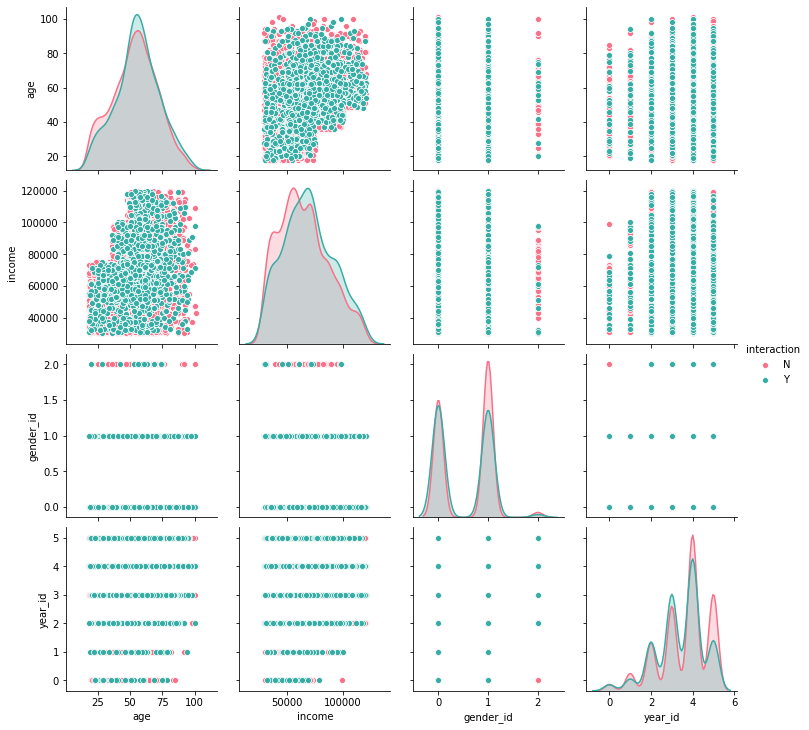

In [35]:
#used 3% of the dataset, otherwise it will take too much time to graph it
df_bogo = bogo.sample(5000).copy()
df_bogo["interaction"] = np.where(df_bogo["event_id"] == 2, "Y", "N")
df_bogo2 = df_bogo[["interaction", "age", "income", "gender_id", "year_id"]]

sns.pairplot(df_bogo2, hue="interaction", palette="husl")
plt.title('Pairplot of 5000 BOGO offer sampels')

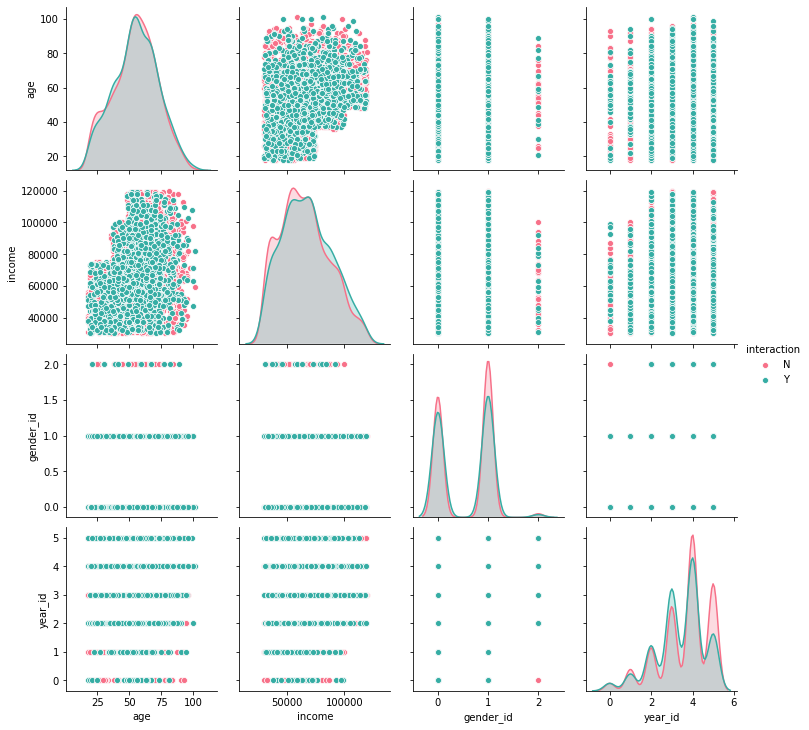

In [36]:
df_discount = discount.sample(5000).copy()
df_discount["interaction"] = np.where(df_discount["event_id"] == 2, "Y", "N")
df_discount2 = df_discount[["interaction", "age", "income", "gender_id", "year_id"]]

sns.pairplot(df_discount2, hue="interaction", palette="husl")
plt.title('Pairplot of 5000 discount offer sampels')

### Insight 3: 
For both offers, men has a significantly lower chance of using it. More loyal customers, who have joined for 5-6 years also have a significantly lower chance of using both offers. Comparing the 2 offers, women slighly use BOGO more while men use discount more. 

### Q3: Do people view and then use the offer? or they use the offer without notice it?

In [37]:
offer0_3['interacted'] = 1

person_offer = offer0_3.groupby(['person', 'days','event'])['interacted'].max().unstack(fill_value=0)

<ipython-input-37-6f1df98a0cbf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer0_3['interacted'] = 1


Text(0, 0.5, 'count')

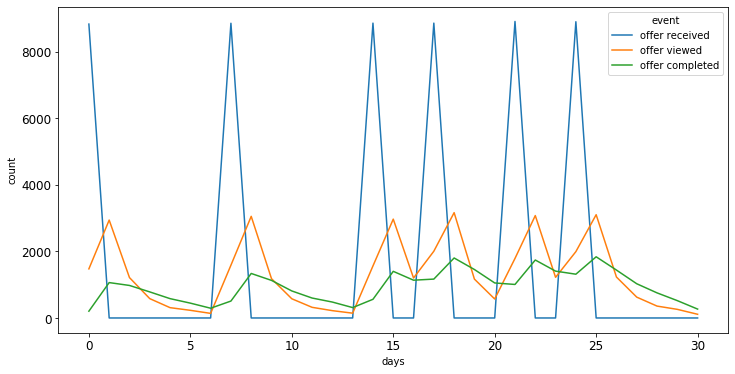

In [38]:
events = list(offer0_3['event'].unique())
ax = person_offer.groupby('days')[events].sum().plot(figsize=(12,6), fontsize=12)
ax.set_xlabel = ('days')
ax.set_ylabel("count")

### Insight 4:
- The peak of offer completed is slighly before offer viewed in the first 5 days of experiment time. They sync better as time goes by indicating that majority of the people still used the offer with conscious.
- the gap between "offer completed" and "offer viewed" also decresed as time goes by

### Q4: which group of people is easier to use the offer/make a purchase without viewing the offer, if there is such a group?

In [39]:
#select the first 2 interactions a person had with an offer
time_0 = offer0_3.sort_values('time').groupby(['person', 'offer_id']).tail(2)
time_0.head()

,person,event,time,gender,age,became_member_on,income,year,days,offer_id,...,channels,difficulty,duration,offer_type,gender_id,event_id,offer_type_id,year_id,channelTye_id,interacted
173437,08a5adf50a9b40a9b5bb24019d0a55fc,offer received,0,M,81,2018-06-21,74000.0,2018,0,f19421c1d4aa40978ebb69ca19b0e20d,...,"[web, email, mobile, social]",5.0,5.0,bogo,1,0,0,5,3,1
248331,55b7b860b3f14ff1bb7e317532de78d0,offer received,0,M,19,2018-02-09,49000.0,2018,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,"[web, email]",20.0,10.0,discount,1,0,3,5,0,1
151457,b8c17e6e004746a4800eeac73461b1dd,offer received,0,M,63,2017-08-04,96000.0,2017,0,ae264e3637204a6fb9bb56bc8210ddfd,...,"[email, mobile, social]",10.0,7.0,bogo,1,0,0,4,1,1
248316,f9c27f6e2fe2441e97db37db2ba3cc17,offer received,0,M,59,2017-10-28,50000.0,2017,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,"[web, email]",20.0,10.0,discount,1,0,3,4,0,1
173451,ab68c87257344ba7963064dd8b4b9350,offer received,0,M,68,2017-10-09,33000.0,2017,0,f19421c1d4aa40978ebb69ca19b0e20d,...,"[web, email, mobile, social]",5.0,5.0,bogo,1,0,0,4,3,1


In [40]:
#demonstration of the dataset for 1 user
time_0[time_0['person'] == '08a5adf50a9b40a9b5bb24019d0a55fc']

,person,event,time,gender,age,became_member_on,income,year,days,offer_id,...,channels,difficulty,duration,offer_type,gender_id,event_id,offer_type_id,year_id,channelTye_id,interacted
173437,08a5adf50a9b40a9b5bb24019d0a55fc,offer received,0,M,81,2018-06-21,74000.0,2018,0,f19421c1d4aa40978ebb69ca19b0e20d,...,"[web, email, mobile, social]",5.0,5.0,bogo,1,0,0,5,3,1
173438,08a5adf50a9b40a9b5bb24019d0a55fc,offer viewed,84,M,81,2018-06-21,74000.0,2018,4,f19421c1d4aa40978ebb69ca19b0e20d,...,"[web, email, mobile, social]",5.0,5.0,bogo,1,1,0,5,3,1
189328,08a5adf50a9b40a9b5bb24019d0a55fc,offer received,336,M,81,2018-06-21,74000.0,2018,14,2906b810c7d4411798c6938adc9daaa5,...,"[web, email, mobile]",10.0,7.0,discount,1,0,3,5,2,1
215092,08a5adf50a9b40a9b5bb24019d0a55fc,offer viewed,408,M,81,2018-06-21,74000.0,2018,17,fafdcd668e3743c1bb461111dcafc2a4,...,"[web, email, mobile, social]",10.0,10.0,discount,1,1,3,5,3,1
189329,08a5adf50a9b40a9b5bb24019d0a55fc,offer completed,414,M,81,2018-06-21,74000.0,2018,18,2906b810c7d4411798c6938adc9daaa5,...,"[web, email, mobile]",10.0,7.0,discount,1,2,3,5,2,1
215093,08a5adf50a9b40a9b5bb24019d0a55fc,offer completed,414,M,81,2018-06-21,74000.0,2018,18,fafdcd668e3743c1bb461111dcafc2a4,...,"[web, email, mobile, social]",10.0,10.0,discount,1,2,3,5,3,1
233037,08a5adf50a9b40a9b5bb24019d0a55fc,offer viewed,600,M,81,2018-06-21,74000.0,2018,25,2298d6c36e964ae4a3e7e9706d1fb8c2,...,"[web, email, mobile, social]",7.0,7.0,discount,1,1,3,5,3,1
233038,08a5adf50a9b40a9b5bb24019d0a55fc,offer completed,642,M,81,2018-06-21,74000.0,2018,27,2298d6c36e964ae4a3e7e9706d1fb8c2,...,"[web, email, mobile, social]",7.0,7.0,discount,1,2,3,5,3,1


In [41]:
#dataset with users first interaction
#first_event= time_0.sort_values('time').groupby(['person', 'offer_id']).min()
#first_event.to_pickle("./firstEvent.pkl")

In [42]:
#dataset with users second interaction
#second_event= time_0.sort_values('time').groupby(['person', 'offer_id']).max()
#second_event.to_pickle("./secondEvent.pkl")

In [43]:
first_event = pd.read_pickle("./firstEvent.pkl")
second_event= pd.read_pickle("./secondEvent.pkl")

In [44]:
#we only want to examine the users who received an offer and compelted it without viewing
event1 = first_event[first_event['event']=='offer received']
event2 = second_event[second_event['event']=='offer completed']

#a list of [person, offer id] whose first intereaction with the offer was 'offer received'
lst1 = []

#a list of [person, offer id] whose second intereaction with the offer was 'offer completed'
lst2 = [] 

for x in range(len(event1)):
    person = event1.index[x]
    lst1.append(person)

for y in range(len(event2)):
    person = event2.index[y]
    lst2.append(person)

print(lst1[0], lst2[0])

('0020c2b971eb4e9188eac86d93036a77', 'ae264e3637204a6fb9bb56bc8210ddfd') ('01925607d99c460996c281f17cdbb9e2', '4d5c57ea9a6940dd891ad53e9dbe8da0')


In [45]:
from collections import Counter

In [46]:
#take out only the person ids
person1 = [lst1[x][0] for x in range(len(lst1))]
person2 = [lst2[x][0] for x in range(len(lst2))]

#found the people that exist in both lists
c = Counter(person1) & Counter(person2)
#a list of people whom completed an offer without viewing it
person_list = list(c.keys())

In [47]:
#we want to study these people. Therefore, we label them in the profile dataset
profile['problem'] = np.where(profile.id.isin(person_list), 1, 0)

profile.sample(5)

,gender,age,id,became_member_on,income,problem
11111,None,118,482bfde0e0bb47d7bc5f4c45b8a892d0,20151112,NaN,0
13649,M,57,8c3be843043c4ed9893ad9aef2a3c71a,20171114,59000.0,0
4375,F,39,acc542a6f04a4950a5aa9121063d5b1f,20171229,31000.0,0
677,M,73,af74271eb39449619fd3bc60e7b0bce4,20140124,63000.0,0
3152,F,94,9994b51cc1ba43ef969f4a798434ba97,20150908,68000.0,0


In [48]:
def clean_profile(df):
    clean_df = df[df['gender'].notnull()].copy() #drop null values
    
    #change became_member_on to datetime formate
    clean_df['became_member_on'] = pd.to_datetime(clean_df['became_member_on'], format='%Y%m%d')
    # create a new column that has the year which customers become members
    clean_df['year'] = clean_df['became_member_on'].apply(lambda x: str(x)[:4])

    return clean_df
    

clean_profile = clean_profile(profile)
clean_profile.head()

,gender,age,id,became_member_on,income,problem,year
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,2017
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0,2017
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,2018
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,2018
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,2017


In [49]:
def boxplots(df, variables, hue, n_rows=None, n_cols=None):
    '''Draw boxplots to examine the churn behavior of each continuous variable. 

    Args:
    variables: list. A list of variables that you would like to examine
    n_rows, n_cols: int. 
    hue: Because the context here is a churn analysis, so I set the default to "Churn". 
    
    Returns:
    boxplots of all the variables that were passed in the format of that you specify. 
    '''
    fig=plt.figure(figsize=(12,6))
    sns.set(palette='pastel')
    for i, var in enumerate(variables):
        ax=fig.add_subplot(n_rows, n_cols, i+1)
        sns.boxplot(y=var, x=hue, hue=hue, data=df, ax=ax).set_title(var)
    plt.show()

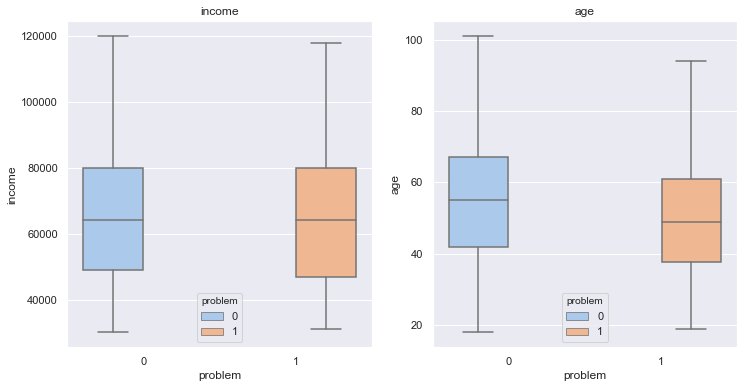

In [50]:
var=['income', 'age']
boxplots(df=clean_profile, variables=var, hue="problem", n_rows=1, n_cols=2,)

In [51]:
problem_df = clean_profile[clean_profile['problem']==1]
no_problem = clean_profile[clean_profile['problem']==0]

Text(0, 1.0, 'Comparing the propotion of joining year b/w the problematic profiles and the rest\n')

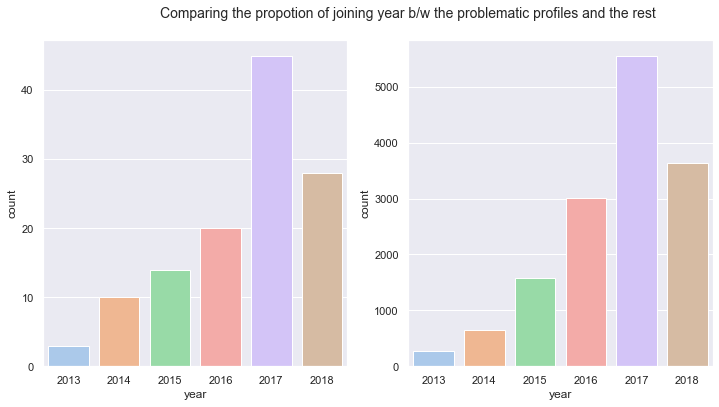

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(x="year", data=problem_df, palette="pastel", ax=ax[0])
sns.countplot(x="year", data=no_problem, palette="pastel", ax=ax[1])
plt.title("""Comparing the propotion of joining year b/w the problematic profiles and the rest\n""", x=0, fontsize=14)

Text(0, 1.0, 'Comparing the propotion of genders b/w the problematic profiles and the rest\n')

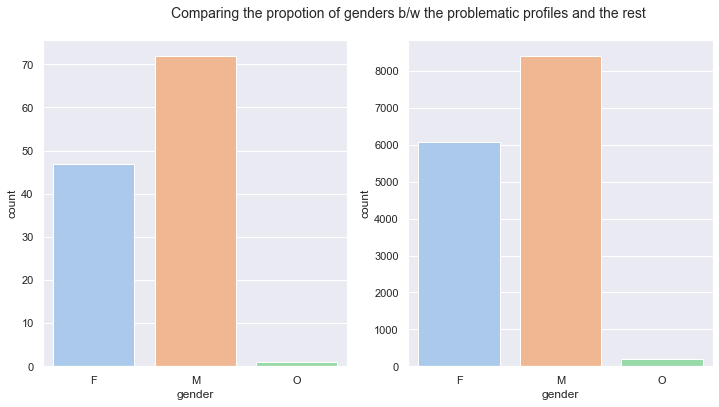

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(x="gender", data=problem_df, palette="pastel", ax=ax[0])
sns.countplot(x="gender", data=no_problem, palette="pastel", ax=ax[1])
plt.title("Comparing the propotion of genders b/w the problematic profiles and the rest\n", x=0, fontsize=14)

### Insight 5: 
Comparing the demographics between customers who used our offers before viewing it and the rest of the customers, there's no significant difference. This indicates that all customers are equally likely to use our offers accidentally.

### Q5: Which type of offer is easier to be used without even noticing by the user, if there is one?

In [54]:
#offer ids of the first user-offer interactions that were 'offer received'
offer1 = [lst1[x][1] for x in range(len(lst1))]

#offer ids of the second user-offer interactions that were 'offer completed'
offer2 = [lst2[x][1] for x in range(len(lst2))]

#find the common offer ids and count how many times they appeared
offer_count = Counter(offer1) & Counter(offer2)
offer_count

Counter({'ae264e3637204a6fb9bb56bc8210ddfd': 27,
         '0b1e1539f2cc45b7b9fa7c272da2e1d7': 84,
         '2906b810c7d4411798c6938adc9daaa5': 38,
         'fafdcd668e3743c1bb461111dcafc2a4': 48,
         '4d5c57ea9a6940dd891ad53e9dbe8da0': 18,
         '9b98b8c7a33c4b65b9aebfe6a799e6d9': 32,
         'f19421c1d4aa40978ebb69ca19b0e20d': 12,
         '2298d6c36e964ae4a3e7e9706d1fb8c2': 29})

In [55]:
def counter2df(counter):
    #turn the counter object to dataframe
    df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
    #rename the columns
    df.rename(columns={'index':'offer id', 0:'count'},inplace=True)
    
    #merge it with the portfolio dataframe so that we can what these offers are
    newdf = portfolio.merge(df, left_on='id', right_on='offer id', how='inner')
    #sort the offers
    newdf.sort_values(by='count', ascending=False, inplace=True)
    return newdf

In [56]:
problemOffers_df = counter2df(offer_count)
problemOffers_df

,reward,channels,difficulty,duration,offer_type,id,offer id,count
3,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,84
5,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,48
7,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5,38
2,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9,32
4,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,2298d6c36e964ae4a3e7e9706d1fb8c2,29
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,ae264e3637204a6fb9bb56bc8210ddfd,27
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,4d5c57ea9a6940dd891ad53e9dbe8da0,18
6,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,12


In [57]:
all0_3_offers = offer0_3[offer0_3['event']=='offer received']
all_offer_count = Counter(all0_3_offers['offer_id'])
all_offer_count

Counter({'9b98b8c7a33c4b65b9aebfe6a799e6d9': 6685,
         'ae264e3637204a6fb9bb56bc8210ddfd': 6683,
         'f19421c1d4aa40978ebb69ca19b0e20d': 6576,
         '2906b810c7d4411798c6938adc9daaa5': 6631,
         'fafdcd668e3743c1bb461111dcafc2a4': 6652,
         '2298d6c36e964ae4a3e7e9706d1fb8c2': 6655,
         '0b1e1539f2cc45b7b9fa7c272da2e1d7': 6726,
         '4d5c57ea9a6940dd891ad53e9dbe8da0': 6593})

In [58]:
#turn counter to df and merge it with porfolio, sorted
allOffers_df = counter2df(all_offer_count)
allOffers_df

,reward,channels,difficulty,duration,offer_type,id,offer id,count
3,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726
2,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,ae264e3637204a6fb9bb56bc8210ddfd,6683
4,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,2298d6c36e964ae4a3e7e9706d1fb8c2,6655
5,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,6652
7,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5,6631
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,4d5c57ea9a6940dd891ad53e9dbe8da0,6593
6,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,6576


In [59]:
all_offerdf_labels = [x[-3:] for x in allOffers_df['id']]
problem_offerdf_labels = [x[-3:] for x in problemOffers_df['id']]

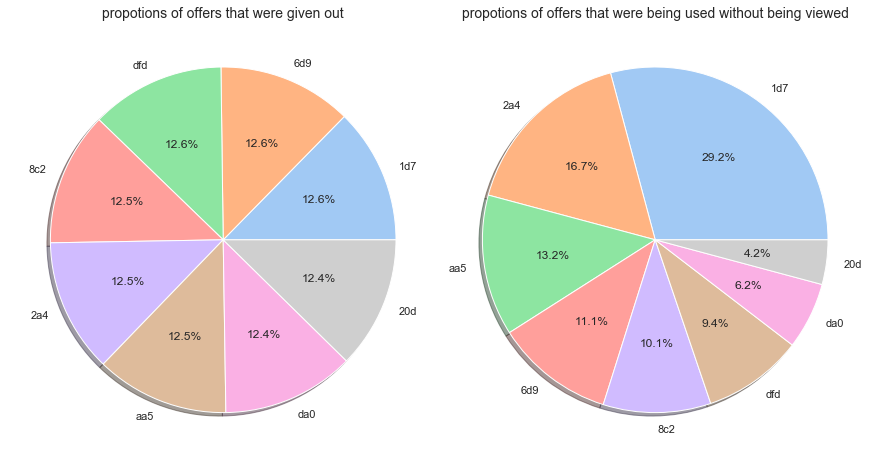

In [121]:
fig = plt.figure()

ax1 = fig.add_axes([0, 0, 1, 2], aspect=1)
ax1.pie(allOffers_df['count'], labels=all_offerdf_labels, autopct='%1.1f%%', shadow=True)
plt.title('propotions of offers that were given out', fontsize=14)

ax2 = fig.add_axes([1, .0, 1, 2], aspect=1)
ax2.pie(problemOffers_df['count'], labels=problem_offerdf_labels, autopct='%1.1f%%', shadow=True)
plt.title('propotions of offers that were being used without being viewed', fontsize=14)
plt.show()

### Insight 6: The design of the offer plays a big role, especially the promotion channels and duration.
- If an offer is being promoted through web and email, then it has a much greater chance of not being seen
- Being used wihout viewing to link to the duration of the offers. Longer duration increase the chance
- discount offer type also has a greater chance to be used without seeing compare to bogo

<a id="4"></a>
## 4. Modelling 

**Goal: identify which user is likely to "waste" an offer (not using the offer or used the offer without viewing it)**

<a id="4.1"></a>
### 4.1 Create a new dataframe with the right classification label for modelling

Classification Label = "wasted" (did not use the offer OR used without viewing it)

In [61]:
full_df['interacted'] = 1
person_all_offers = full_df.groupby(['person', 'offer_id','event'])['interacted'].max().unstack(fill_value=0)

#if a person (did not use an offer) or (used it without viewing), then the offer is wasted
person_all_offers['wasted'] = np.where((person_all_offers["offer completed"]==1)&(person_all_offers["offer viewed"]==1), 0, 1)
person_all_offers

event                                                              offer completed  \
person                           offer_id                                            
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5                1   
                                 3f207df678b143eea3cee63160fa8bed                0   
                                 5a8bc65990b245e5a138643cd4eb9837                0   
                                 f19421c1d4aa40978ebb69ca19b0e20d                1   
                                 fafdcd668e3743c1bb461111dcafc2a4                1   
...                                                                            ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d                1   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7                1   
                                 2906b810c7d4411798c6938adc9daaa5                1   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9                1   
                                 fafdcd668e3743c1bb461111dcafc2a4                1   

event                                                              offer received  \
person                           offer_id                                           
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5               1   
                                 3f207df678b143eea3cee63160fa8bed               1   
                                 5a8bc65990b245e5a138643cd4eb9837               1   
                                 f19421c1d4aa40978ebb69ca19b0e20d               1   
                                 fafdcd668e3743c1bb461111dcafc2a4               1   
...                                                                           ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d               1   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7               1   
                                 2906b810c7d4411798c6938adc9daaa5               1   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9               1   
                                 fafdcd668e3743c1bb461111dcafc2a4               1   

event                                                              offer viewed  \
person                           offer_id                                         
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5             0   
                                 3f207df678b143eea3cee63160fa8bed             1   
                                 5a8bc65990b245e5a138643cd4eb9837             1   
                                 f19421c1d4aa40978ebb69ca19b0e20d             1   
                                 fafdcd668e3743c1bb461111dcafc2a4             1   
...                                                                         ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d             1   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7             1   
                                 2906b810c7d4411798c6938adc9daaa5             1   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9             1   
                                 fafdcd668e3743c1bb461111dcafc2a4             1   

event                                                              wasted  
person                           offer_id                                  
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       1  
                                 3f207df678b143eea3cee63160fa8bed       1  
                                 5a8bc65990b245e5a138643cd4eb9837       1  
                                 f19421c1d4aa40978ebb69ca19b0e20d       0  
                                 fafdcd668e3743c1bb461111dcafc2a4       0  
...                                                                   ...  
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d       0  
ffff82501ce

In [62]:
#creating a new dataframe with only the information that we need to build the model
model_df = person_all_offers['wasted']
model_df.reset_index(level=['person', 'offer_id'])
model_df= model_df.to_frame().reset_index()
model_df.head()

,person,offer_id,wasted
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0


In [63]:
#get the information we need from the profile dataframe
model_df = model_df.merge(clean_profile, left_on='person', right_on='id', how='left')
model_df.drop(['id','problem', 'became_member_on'], axis=1, inplace=True)
model_df.head()

,person,offer_id,wasted,gender,age,income,year
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,M,33,72000.0,2017
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,M,33,72000.0,2017
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,M,33,72000.0,2017
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,M,33,72000.0,2017
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,M,33,72000.0,2017


In [64]:
#get the information we need from the portfolio dataframe
model_df = model_df.merge(portfolio, left_on='offer_id', right_on='id', how='left')
model_df.drop(['id'], axis=1, inplace=True)
model_df.head()

,person,offer_id,wasted,gender,age,income,year,reward,channels,difficulty,duration,offer_type
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,M,33,72000.0,2017,2,"[web, email, mobile]",10,7,discount
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,M,33,72000.0,2017,0,"[web, email, mobile]",0,4,informational
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,M,33,72000.0,2017,0,"[email, mobile, social]",0,3,informational
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,M,33,72000.0,2017,5,"[web, email, mobile, social]",5,5,bogo
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,M,33,72000.0,2017,2,"[web, email, mobile, social]",10,10,discount


In [65]:
#clean the dataframe by using the function we wrote before
clean_model_df = clean_allcat(model_df, ['gender', 'offer_type', 'offer_id'])
clean_model_df.drop(['gender', 'offer_type', 'offer_id', 'channels', 'year'], axis=1, inplace=True)
clean_model_df.head()

,person,wasted,age,income,reward,difficulty,duration,gender_id,offer_type_id,offer_id_id,year_id,channelTye_id
0,0009655768c64bdeb2e877511632db8f,1,33,72000.0,2,10,7,0,0,0,4,2
1,0009655768c64bdeb2e877511632db8f,1,33,72000.0,0,0,4,0,1,1,4,2
2,0009655768c64bdeb2e877511632db8f,1,33,72000.0,0,0,3,0,1,2,4,1
3,0009655768c64bdeb2e877511632db8f,0,33,72000.0,5,5,5,0,2,3,4,3
4,0009655768c64bdeb2e877511632db8f,0,33,72000.0,2,10,10,0,0,4,4,3


<a id="4.2"></a>
### 4.2: Modelling and Evaluation

In [98]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [122]:
clean_model_df.sample(5)

,person,wasted,age,income,reward,difficulty,duration,gender_id,offer_type_id,offer_id_id,year_id,channelTye_id
47687,dcbfaa28be964747816df91af895f69d,1,69,106000.0,5,20,10,0,0,5,4,0
40853,bbb98c130cf441f6a1e360436565b697,0,70,64000.0,5,5,5,2,2,3,1,3
4989,17c90aeaed6f4f91991eaa59ad2805b0,1,42,63000.0,5,5,5,2,2,3,5,3
3527,10b64048925443fd8ec2792ea63de78c,0,66,34000.0,2,10,10,0,0,4,3,3
41652,bfbad17bdb5343aa89d2424dbf4fe969,1,58,75000.0,10,10,5,0,2,8,5,3


In [124]:
#want to see how imbalanced is the dataset
clean_model_df['wasted'].value_counts()

1    31723
0    23499
Name: wasted, dtype: int64

In [83]:
#data preperation
label = clean_model_df['wasted']
train = clean_model_df.iloc[:, 2:].copy()

#Dividing the data into train and test
X_train, X_test, y_train, y_test = train_test_split(train, label,test_size=0.20, random_state=1)

# normalizing some numerical values
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

X_train = pd.DataFrame(MinMaxScaler().fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(MinMaxScaler().fit_transform(X_test), columns=X_test.columns, index=X_test.index)

#building model
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)

In [102]:
#we can see how confident we are for each perdiction
logisticRegr.predict_proba(X_test)

array([[0.63205772, 0.36794228],
       [0.00574156, 0.99425844],
       [0.42028443, 0.57971557],
       ...,
       [0.45100566, 0.54899434],
       [0.70872067, 0.29127933],
       [0.37009745, 0.62990255]])

In [123]:
# Use score method to get accuracy of model
score = accuracy_score(y_test, predictions)
print('The accuracy score of the model to predict if an offer will be wasted is {}'.format(score))

the accuracy score of the model to predict if an offer will be wasted is 0.7136260751471254


In [97]:
from sklearn.metrics import confusion_matrix
cfm = confusion_matrix(np.array(y_test),predictions)
print(cfm)

[[3055 1649]
 [1514 4827]]


False Positive performed worse than False Negative, meaning that the model is more accurate at identifying which offer will be wasted, not which offer will be used. This is essential the money-saving approach for a marketing team.

<a id='5'></a>

## Conclusion

Based on my analysis, I conclude the following: 
- Customers with incomplete profiles are less likely to use offers.
- Customers whom joinied ealier, for example 4+ year, they are a lot less likely to use offers.
- Men are less likely to use offers but they do prefer discount over BOGO, while women used BOGO more.

I suggest the following:
- To advoid or to improve the situation of using an offer without viewing:
    - need to promote the offer via at least 3 channels to increase exposure
    - eliminate offers that last for 10 days, put max. 7 days. If an offer is really hard, level 20, a customer is much less likely to work towards it. Meanwhile, those people who achieved it are likely to achieve that amount of spending regardless of the offer.
- There are lots of potential in the discount offer. The completion rate is 78% among those whom viewed the offer. Therefore, if the company can increase the viewing rate of discount offer, there's a great chance to incentive more spending.

Future Improvement:
- incoporate the data from information offer
- improve the model accuracy by fine tuning the model or try tree models
